In [1]:
## pneumothorax heatmap
## 利用在chestx-ray8数据集上的训练的分类网络的特征图，在气胸数据集上，查看heatmap效果，并与气胸分割图进行比对

In [2]:
from glob import glob
import os
import pandas as pd
import pydicom
import matplotlib.pyplot as plt

#checnking the input files
# print(os.listdir("../input/siim-acr-pneumothorax-segmentation-data"))

#reading all dcm files into train and text
train = sorted(glob("pneumothorax/dicom-images-train/*/*/*.dcm"))
test = sorted(glob("pneumothorax/dicom-images-test/*/*/*.dcm"))
print("train files: ", len(train))
print("test files: ", len(test))

pd.reset_option('max_colwidth')

#reading the csv
print("the csv with the labels: -1 means no Pneumothorax, othervise there is an encoding for the place of Pneumothorax")
masks = pd.read_csv("pneumothorax/train-rle.csv", delimiter=",")
masks.head()

train files:  12089
test files:  3205
the csv with the labels: -1 means no Pneumothorax, othervise there is an encoding for the place of Pneumothorax


,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...


In [3]:
#dataframe to ease the access
patients = []
missing = 0

pd.reset_option('max_colwidth')

for t in train:
    data = pydicom.dcmread(t)
    patient = {}
    patient["UID"] = data.SOPInstanceUID
    try:
        encoded_pixels = masks[masks["ImageId"] == patient["UID"]].values[0][1]
        patient["EncodedPixels"] = encoded_pixels
    except:
        missing = missing + 1
    patient["Age"] = data.PatientAge
    patient["Sex"] = data.PatientSex
    patient["Modality"] = data.Modality
    patient["BodyPart"] = data.BodyPartExamined
    patient["ViewPosition"] = data.ViewPosition
    patient["path"] = "pneumothorax/dicom-images-train/" + data.StudyInstanceUID + "/" + data.SeriesInstanceUID + "/" + data.SOPInstanceUID + ".dcm"
    patients.append(patient)

print("missing labels: ", missing)
#pd.set_option('display.max_colwidth', -1)
df_patients = pd.DataFrame(patients, columns=["UID", "EncodedPixels", "Age", "Sex", "Modality", "BodyPart", "ViewPosition", "path"])
print("images with labels: ", df_patients.shape[0])
df_patients.head()

missing labels:  42
images with labels:  12089


,UID,EncodedPixels,Age,Sex,Modality,BodyPart,ViewPosition,path
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,-1,38,M,CR,CHEST,PA,pneumothorax/dicom-images-train/1.2.276.0.7230...
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,-1,10,F,CR,CHEST,AP,pneumothorax/dicom-images-train/1.2.276.0.7230...
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,-1,50,F,CR,CHEST,AP,pneumothorax/dicom-images-train/1.2.276.0.7230...
3,1.2.276.0.7230010.3.1.4.8323329.10002.15178752...,-1,68,F,CR,CHEST,AP,pneumothorax/dicom-images-train/1.2.276.0.7230...
4,1.2.276.0.7230010.3.1.4.8323329.10003.15178752...,-1,65,M,CR,CHEST,AP,pneumothorax/dicom-images-train/1.2.276.0.7230...


In [4]:
#mask functions from sample dataset
import numpy as np

def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

57 F


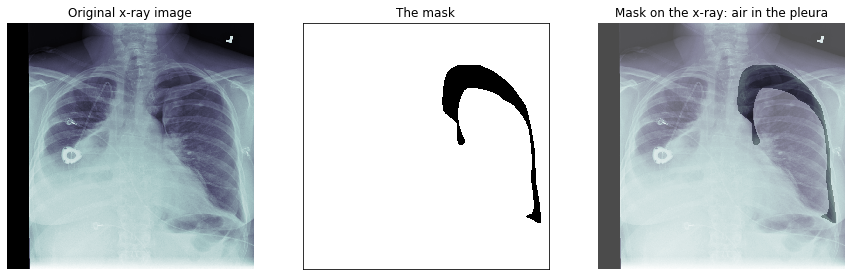

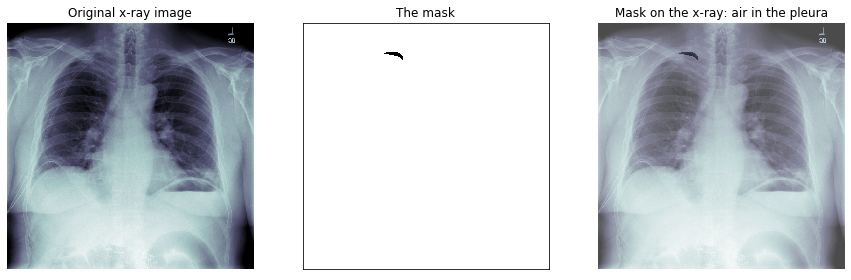

In [10]:
df_pneumo = df_patients[df_patients["EncodedPixels"] != '-1']

print(df_pneumo.values[3][2], df_pneumo.values[3][3])

mask = rle2mask(df_pneumo.values[3][1], 1024, 1024)
mask = np.rot90(mask, 3) #rotating three times 90 to the right place
mask = np.flip(mask, axis=1)

img = pydicom.read_file(df_pneumo.values[3][-1]).pixel_array

fig = plt.figure(figsize=(15, 10))
a = fig.add_subplot(1, 3, 1)
plt.imshow(img, cmap='bone') #original x-ray
a.set_title("Original x-ray image")
plt.grid(False)
plt.axis("off")

a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(mask, cmap='binary')

a.set_title("The mask")
plt.grid(False)
plt.xticks([])
plt.yticks([])

a = fig.add_subplot(1, 3, 3)
plt.imshow(img, cmap='bone')
plt.imshow(mask, cmap='binary', alpha=0.3)
a.set_title("Mask on the x-ray: air in the pleura")

import cv2
cv2.imwrite('./test.png', img)

plt.axis("off")

plt.grid(False)

mask = rle2mask(df_pneumo.values[6][1], 1024, 1024)
mask = np.rot90(mask, 3) #rotating three times 90 to the right place
mask = np.flip(mask, axis=1)
img = pydicom.read_file(df_pneumo.values[6][-1]).pixel_array

fig = plt.figure(figsize=(15, 10))
a = fig.add_subplot(1, 3, 1)
plt.imshow(img, cmap='bone') #original x-ray
a.set_title("Original x-ray image")
plt.grid(False)
plt.axis("off")

a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(mask, cmap='binary')

a.set_title("The mask")
plt.grid(False)
plt.xticks([])
plt.yticks([])

a = fig.add_subplot(1, 3, 3)
plt.imshow(img, cmap='bone')
plt.imshow(mask, cmap='binary', alpha=0.3)
a.set_title("Mask on the x-ray: air in the pleura")

plt.axis("off")

plt.grid(False)
